# Benchmark for Triton FIL backend on the AWS EC2 service

We measure the throughput and latency for inference requests on two EC2 machines:

* `CPU`: c5.4xlarge (32 GiB memory, 16 vCPU cores with Intel Xeon (Cascade Lake); 0.68 USD/hour as of September 2024)
* `GPU`: g4dn.2xlarge (32 GiB memory, 1 Tesla T4 GPU with 16 GiB on-chip memory; 0.752 USD/hour as of September 2024)

The two EC2 instance types were chosen because they cost about the same on per-hour basis.

The decision tree ensemble model has following characteristics. (See `train.py` for the details.)
* XGBoost model with 512 trees
* Training data has 32 features
* Maximum tree depth of 8

Using the `model_analyzer` tool from Triton, we simulate various levels of request traffic, using the following parameters:
* **Batch size**: Number of rows to be processed per inference request. Values: 1, 16, 128, 1024
* **Concurrency**: Number of concurrent requests to be submitted at a given time. Higher values indicate a traffic spike. Values: 1, 2, 4, 8, 16, 32, 64.

We measure on two metrics:

* **Throughput**: Total number of inference requests served per second. The number is normalized by the batch size of each inference request.
* **p99 Latency**: Time it takes for an individual inference request to be completed. Some requests take longer to complete than others, so we look at the distribution of latency measured and take the 99th percentile.

## Results

The following plots suggest that the GPU machine provides substantially higher throughput while keeping the p99 latency low (1 ms - 10 ms).

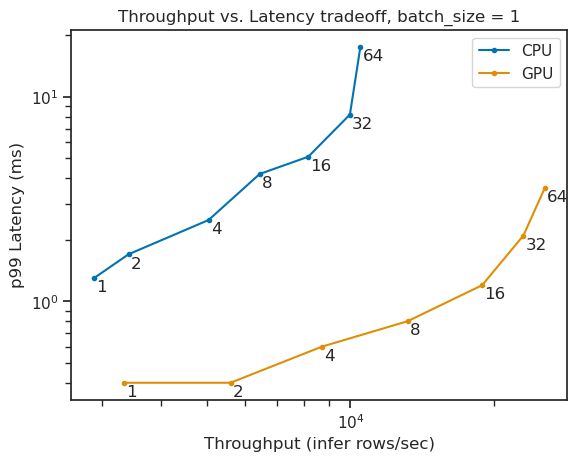

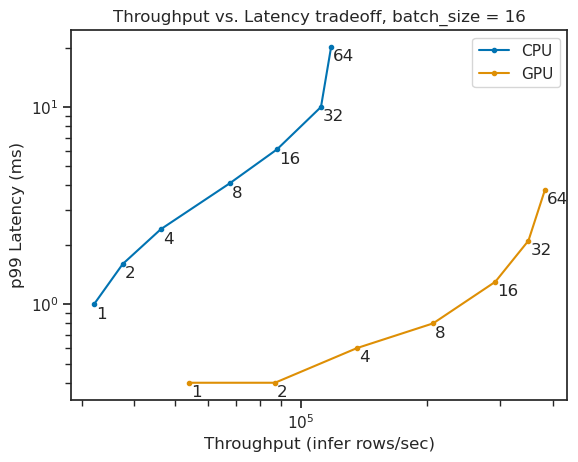

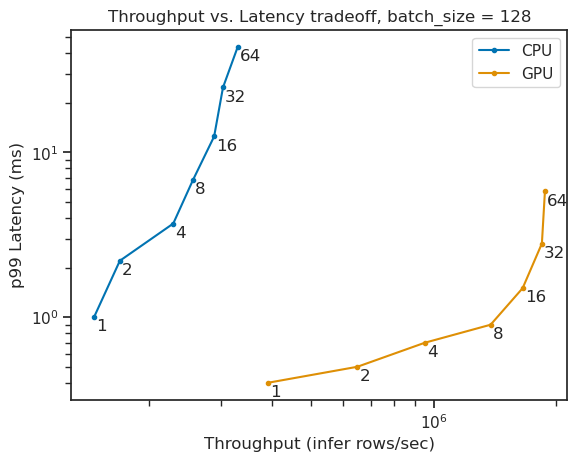

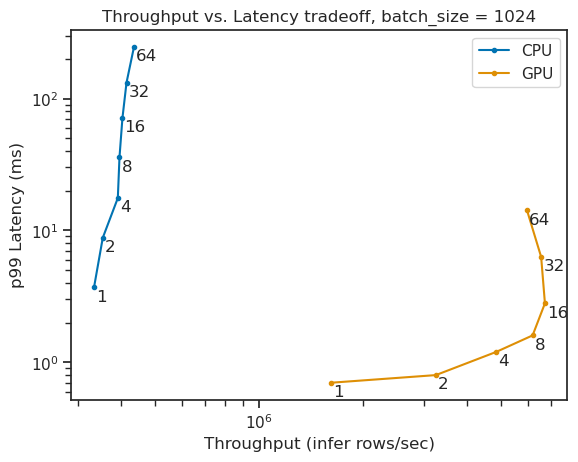

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette=sns.color_palette("colorblind"))

df_cpu = pd.read_csv("cpu.csv")
df_gpu = pd.read_csv("gpu.csv")

for batch_size in np.sort(df_cpu["Batch"].unique()):
    plt.figure()
    for df, label in [(df_cpu, "CPU"), (df_gpu, "GPU")]:
        x = df[df["Batch"] == batch_size].sort_values(by=["Concurrency"])
        plt.plot(x["Throughput (infer/sec)"], x["p99 Latency (ms)"], ".-", label=label)
        for xi, yi, text in zip(x["Throughput (infer/sec)"], x["p99 Latency (ms)"], x["Concurrency"]):
            plt.annotate(text, xy=(xi, yi), xycoords="data",
                         xytext=(1.5, -10), textcoords="offset points")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Throughput (infer rows/sec)")
    plt.ylabel("p99 Latency (ms)")
    plt.title(f"Throughput vs. Latency tradeoff, batch_size = {batch_size}")
    plt.legend(loc="best")